In [4]:
from utils import *
import pandas as pd
import mne
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import normalize, StandardScaler
plt.style.use('seaborn-whitegrid')

# PSS Score

In [5]:
PSS = pd.read_csv("PSS_scores.csv")#, usecols=['name','score'])

lower_thres = PSS['score'].mean() - (PSS['score'].std()/2)
higher_thres = PSS['score'].mean() + (PSS['score'].std()/2)
PSS.sort_values('name', inplace=True)

PSS['Non Stress'] = PSS.score < lower_thres
PSS['Neutral'] = PSS.score.between(lower_thres, higher_thres)
PSS['Stress'] = PSS.score > higher_thres

print(f"Total={len(PSS)} | Mean={PSS['score'].mean()} | Lower Thres={lower_thres} | Higher Thres={higher_thres}")
print(f"Non Stress={sum(PSS['Non Stress'])} | Neutral={sum(PSS['Neutral'])} | Stress={sum(PSS['Stress'])}")
PSS

Total=54 | Mean=20.555555555555557 | Lower Thres=17.42827651238776 | Higher Thres=23.682834598723353
Non Stress=16 | Neutral=19 | Stress=19


,name,score,Non Stress,Neutral,Stress
5,MJ,12,True,False,False
14,amp,13,True,False,False
21,aui,28,False,False,True
37,aun,21,False,True,False
38,bam,24,False,False,True
22,bank,25,False,False,True
1,bas,25,False,False,True
15,beau,9,True,False,False
39,beer,17,True,False,False
7,boss,22,False,True,False


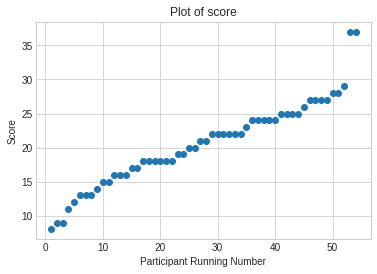

In [6]:
plt.scatter(range(1, len(PSS)+1), list(PSS.sort_values('score')['score']))
plt.xlabel('Participant Running Number')
plt.ylabel('Score')
plt.title('Plot of score')
plt.show()

# Load EEG data

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5722792/

The frontal asymmetry is most commonly computed by subtracting the natural log of left hemisphere alpha power (EEG electrode F3) from the natural log of right hemisphere alpha power (F4) while using the central Cz as reference electrode

In [127]:
PSS["raw"] = ""
sampling_rate = 125 #Hz
files = glob(f"data/*.csv")
for index, f in enumerate(files):
    name = f.split('/')[1].split('__')[0]
    pd_raw = pd.read_csv(f, dtype={'Marker':str})
    pd_raw = pd_raw.drop(columns='timestamps')
    raw = dataframe_to_raw(pd_raw, sfreq=sampling_rate)
    PSS.loc[PSS['name'] == name, 'raw'] = raw
    # print(pd_raw.Marker.unique())
    # pd_raw = marker_converter(pd_raw,marker_names)
    print(f"{index} {name} | time: {len(pd_raw)/125}")
# print(participants)


ValueError: All picks must be < n_channels (17), got 17

In [126]:
PSS

,name,score,Non Stress,Neutral,Stress,raw
5,MJ,12,True,False,False,a
14,amp,13,True,False,False,a
21,aui,28,False,False,True,a
22,bank,25,False,False,True,a
1,bas,25,False,False,True,a
15,beau,9,True,False,False,a
7,boss,22,False,True,False,a
23,dream,19,False,True,False,a
16,dt,16,True,False,False,a
24,eiyu,24,False,False,True,a


In [3]:
raws = []
sampling_rate = 125 # Hz
with tqdm(pd_raws) as pbar:
    for index,pd_raw in enumerate(pbar):
        pbar.set_description(f"{index} {participants[index]}")
        raw = dataframe_to_raw(pd_raw, sfreq=sampling_rate)
        raws.append(raw)

  0%|          | 0/37 [00:00<?, ?it/s]

0 suyo


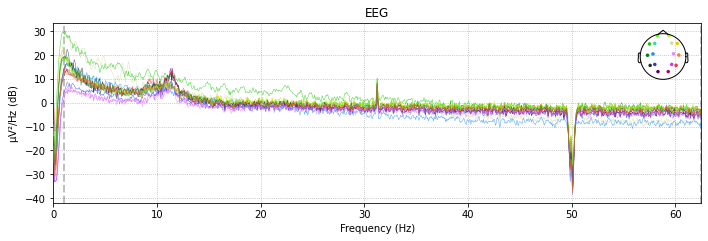

1 beau


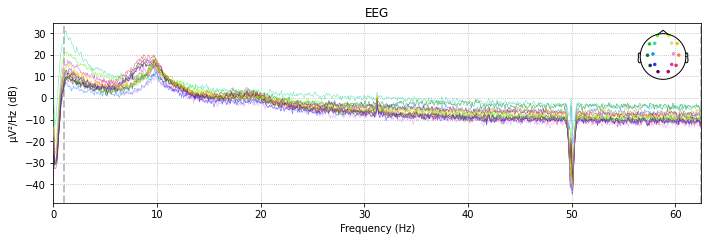

2 eiyu


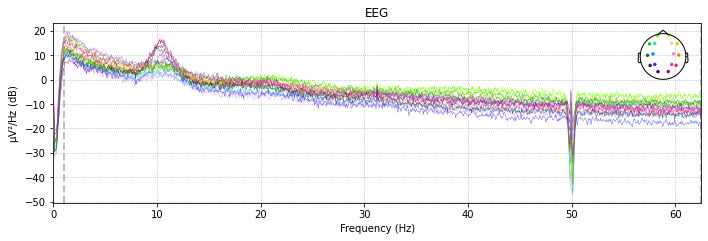

3 nuclear


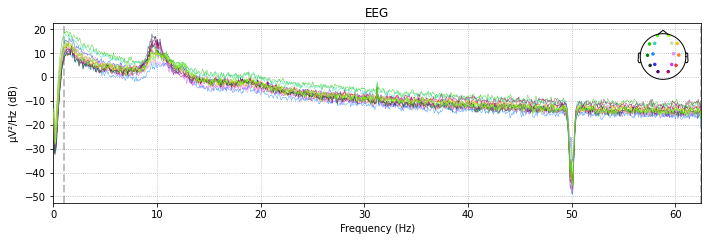

4 minkhant


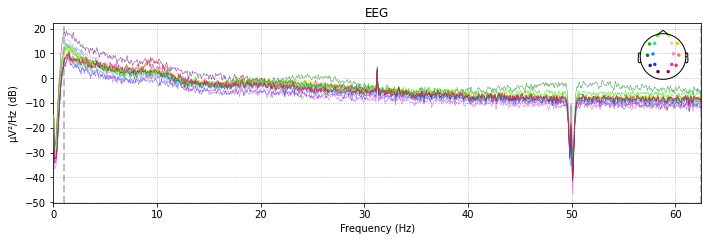

5 pear


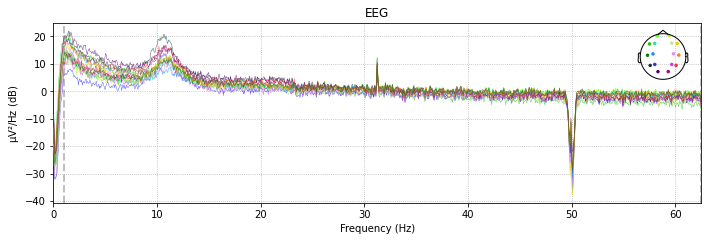

6 dream


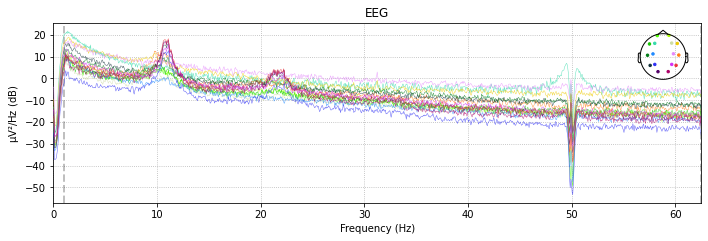

7 new


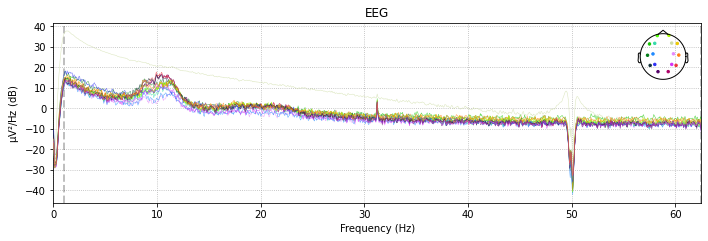

8 sam


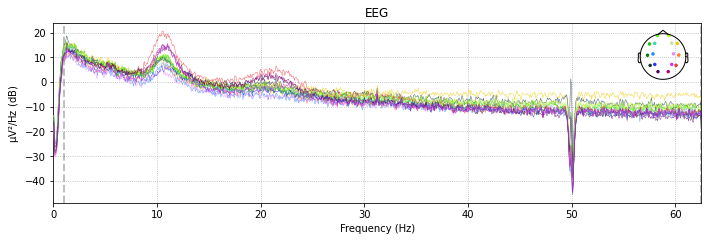

9 miiw


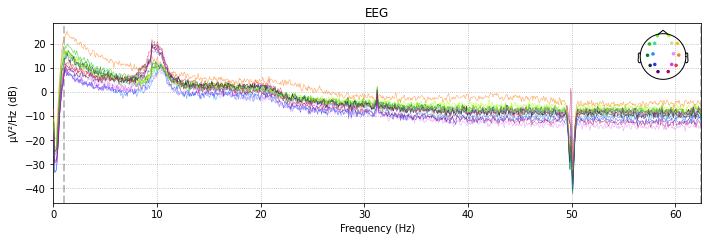

10 job


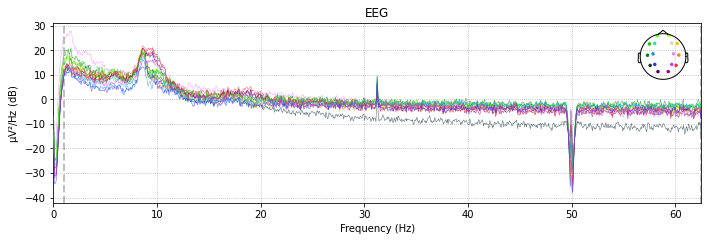

11 yee


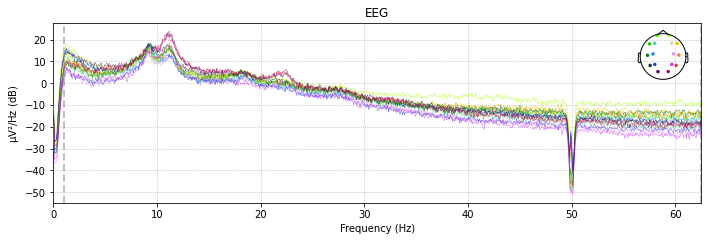

12 tom


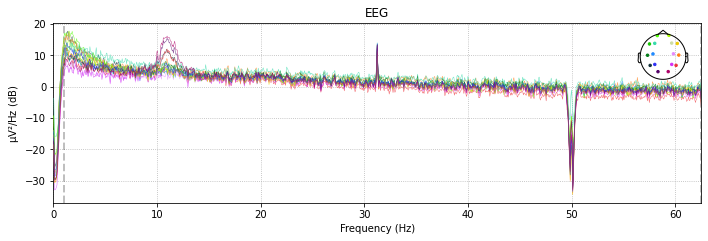

13 fabby


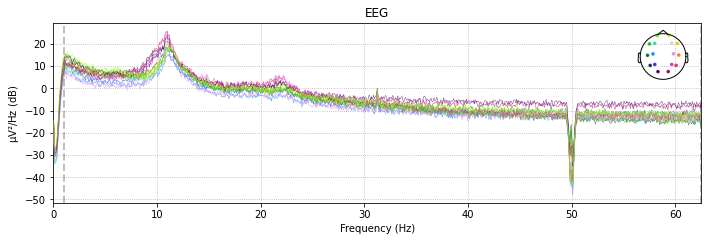

14 nopphon


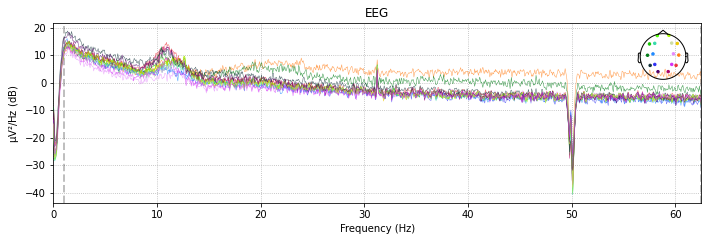

15 prin


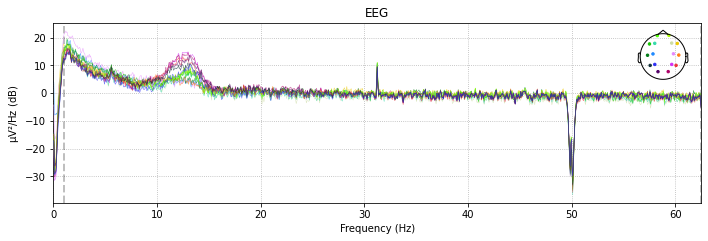

16 film


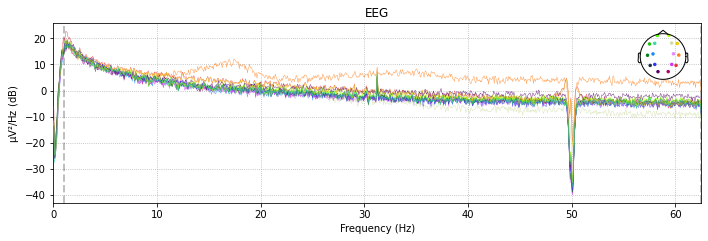

17 yong


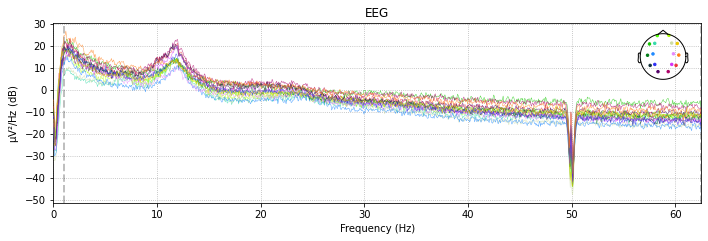

18 MJ


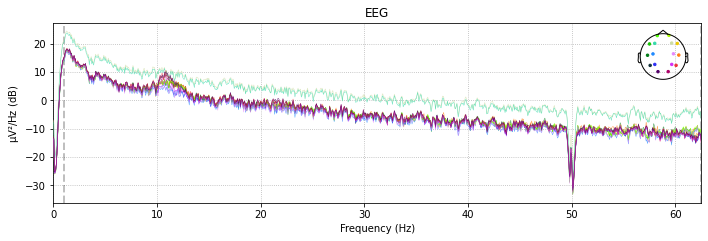

19 nice


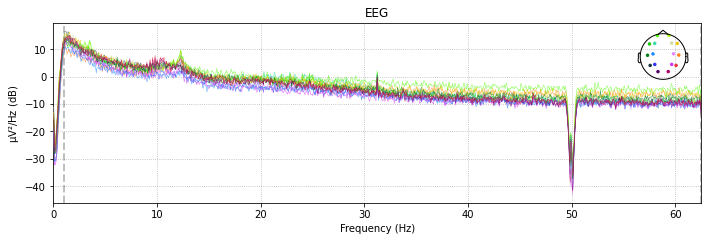

20 bank


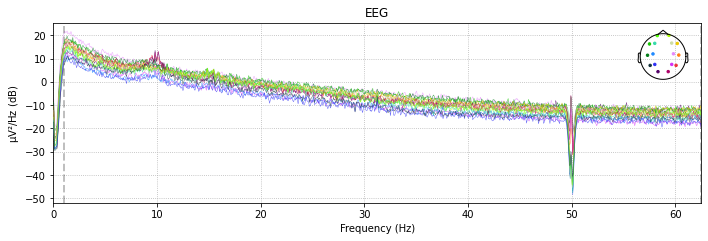

21 shin


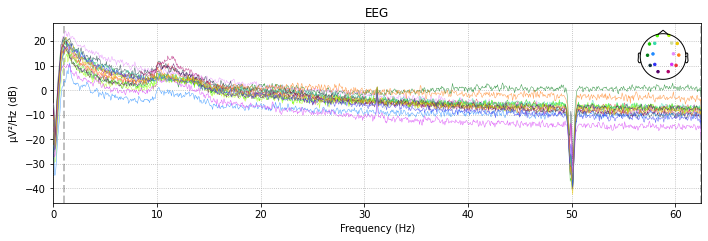

22 dt


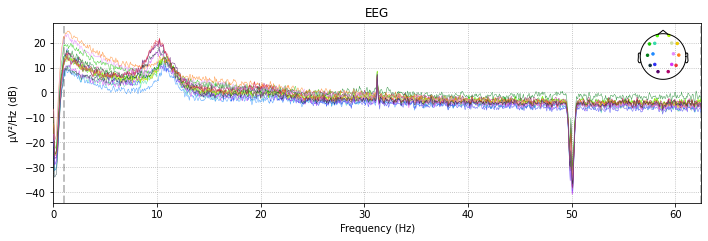

23 flm


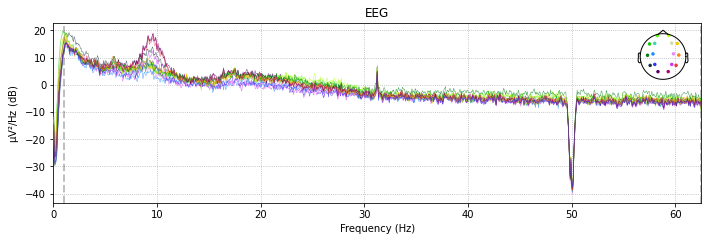

24 bas


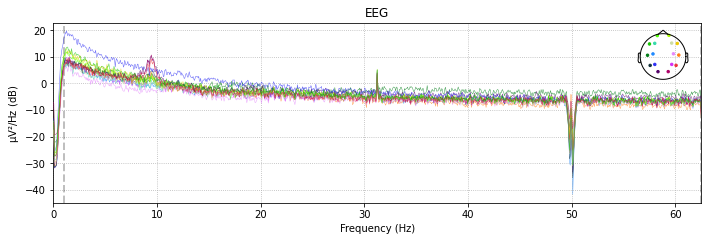

25 kee


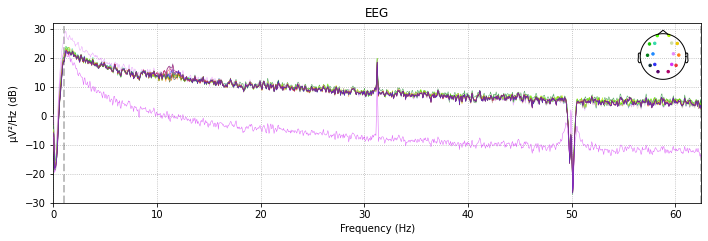

26 aui


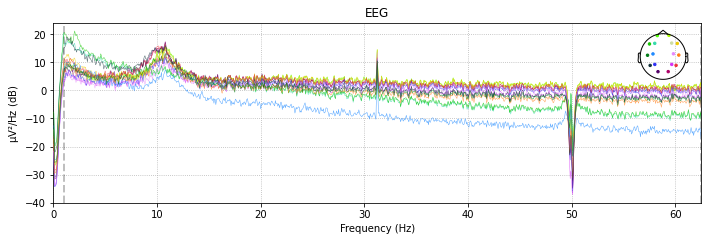

27 ice


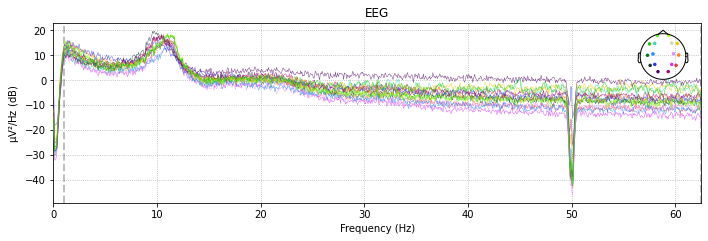

28 int


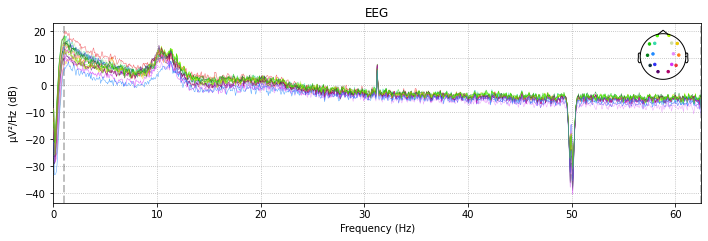

29 taew


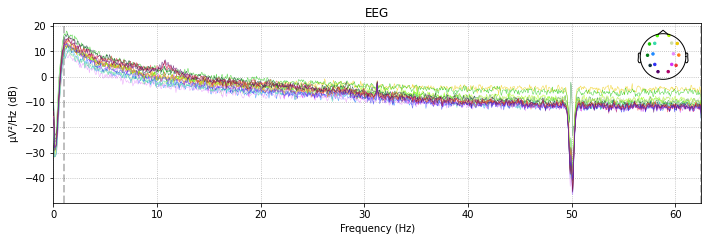

30 noey


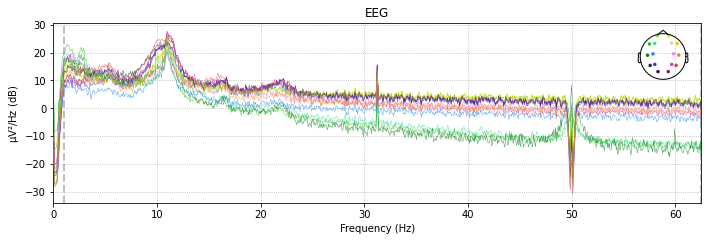

31 por


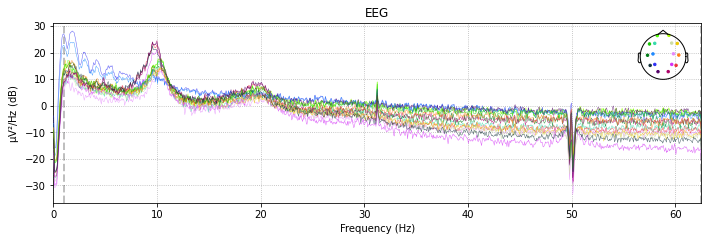

32 pang


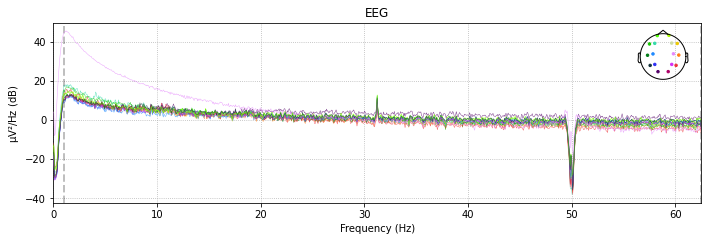

33 satya


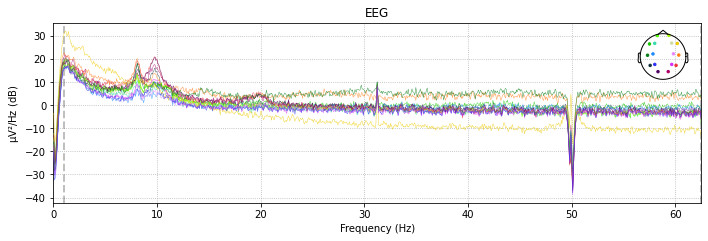

34 boss


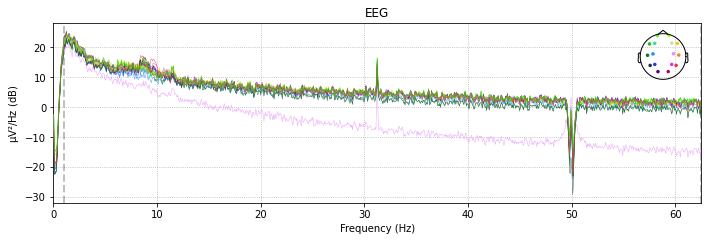

35 mind


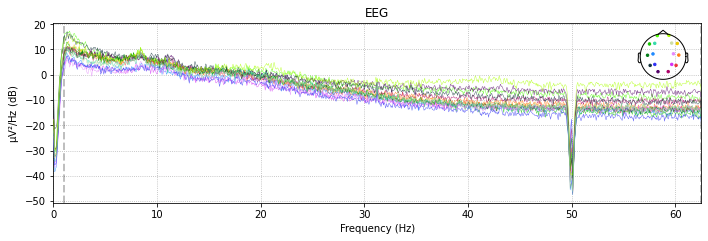

36 amp


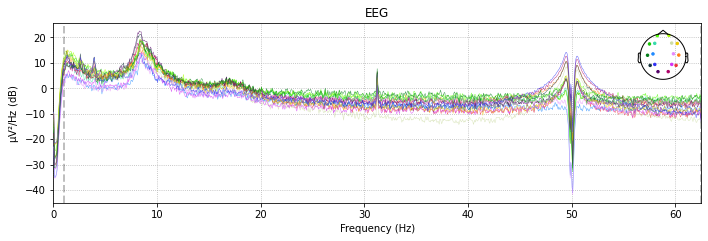

In [4]:
for index,raw in enumerate(raws):
    print(index, participants[index])
    raw.filter(l_freq=1,h_freq=None, method='iir', iir_params={'order':3.0, 'ftype':'butter'}, verbose=False) # Slow drift
    raw.notch_filter(freqs=[50])
    raw.plot_psd()

In [5]:
raw = raws[participants.index('MJ')]
power,freq = mne.time_frequency.psd_welch(raw,n_fft=125, verbose=True)

Effective window size : 1.000 (s)


In [6]:
band_names = np.array(['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'Slow', 'Low_beta'])
filter_list = [[1,3],[4,7],[8,12],[13,30],[30,43], [4,13], [13,17]]
bands = []
for filt in filter_list:
    pt = np.argwhere((freq >= filt[0]) & (freq <= filt[1])).reshape(-1)
    bands.append(pt)
bands = np.array(bands)
print(bands)

[array([1, 2, 3]) array([4, 5, 6, 7]) array([ 8,  9, 10, 11, 12])
 array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
        30])
 array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43])
 array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13])
 array([13, 14, 15, 16, 17])]


<ipython-input-6-3759ae126e95>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bands = np.array(bands)


In [7]:
features = None
for raw in raws:
    feature = None
    slow, gamma = None, None
    a_f3, a_f4 = None, None
    a_t7, a_t8 = None, None
    b_f3, b_f4 = None, None
    b_t7, b_t8 = None, None
    for index, band in enumerate(bands):
        power,freq = mne.time_frequency.psd_welch(raw,n_fft=125, verbose=False)
        power = 10 * np.log10(power)
        data = power[::,band].mean(axis=1).reshape(1,-1)
        # for asym
        if(band_names[index] == 'Alpha'):
            a_f3 = data[:,raw.ch_names.index('F3')]
            a_f4 = data[:,raw.ch_names.index('F4')]
            # We use t3 as t7 and t4 as t8
            a_t7 = data[:,raw.ch_names.index('T3')]
            a_t8 = data[:,raw.ch_names.index('T4')]
        if(band_names[index] == 'Beta'):
            b_f3 = data[:,raw.ch_names.index('F3')]
            b_f4 = data[:,raw.ch_names.index('F4')]
            # We use t3 as t7 and t4 as t8
            b_t7 = data[:,raw.ch_names.index('T3')]
            b_t8 = data[:,raw.ch_names.index('T4')]

        ####### Mean for visualization #######
        data = data.mean().reshape(1,-1)
        # for relative gamma
        if(band_names[index] == 'Slow'): slow = data
        if(band_names[index] == 'Gamma'): gamma = data

        if(type(feature) == type(None)): feature = data
        else: feature = np.concatenate([feature, data], axis=1)
    # print(feature.shape)
    # the eighth feature: relative gamma is slow/gamma
    relative_gamma = slow/gamma
    feature = np.concatenate([feature, relative_gamma], axis=1)
    # The asymetry
    alpha_frontal = ((a_f4 - a_f3) / (a_f4 + a_f3)).reshape(1,-1)
    feature = np.concatenate([feature, alpha_frontal], axis=1)
    # alpha_temporal
    alpha_temporal = ((a_t8 - a_t7) / (a_t8 + a_t7)).reshape(1,-1)
    feature = np.concatenate([feature, alpha_temporal], axis=1)
    # alpha_asymmetry
    alpha_asymmetry = alpha_frontal + alpha_temporal
    feature = np.concatenate([feature, alpha_asymmetry], axis=1)
    # beta_frontal
    beta_frontal = ((b_f4 - b_f3) / (b_f4 + b_f3)).reshape(1,-1)
    feature = np.concatenate([feature, beta_frontal], axis=1)
    # beta_temporal
    beta_temporal = ((b_t8 - b_t7) / (b_t8 + b_t7)).reshape(1,-1)
    feature = np.concatenate([feature, beta_temporal], axis=1)

    # print(slow/gamma)
    # print(feature.shape)
    # print(feature)
    if(type(features) == type(None)): features = feature
    else: features = np.concatenate([features, feature], axis=0)
print(features.shape)


(37, 13)


In [8]:
print(participants)

['suyo', 'beau', 'eiyu', 'nuclear', 'minkhant', 'pear', 'dream', 'new', 'sam', 'miiw', 'job', 'yee', 'tom', 'fabby', 'nopphon', 'prin', 'film', 'yong', 'MJ', 'nice', 'bank', 'shin', 'dt', 'flm', 'bas', 'kee', 'aui', 'ice', 'int', 'taew', 'noey', 'por', 'pang', 'satya', 'boss', 'mind', 'amp']


In [9]:
scores = {
    "fabby": 25,
    "bas": 25,
    "flm": 37,
    "mind": 22,
    # "taew": 21, real value
    "taew": 25, # we thnk she should be
    "MJ": 12,
    "nopphon":22,
    "boss":22,
    "film":18,
    "new":28,
    "nice":18,
    "nuclear":15,
    "pang":29,
    "prin":9,
    "amp":13,
    "beau":9,
    "dt":16,
    "int":15,
    "minkhant":24,
    "sam":18,
    "yong":27,
    "aui":28,
    "bank":25,
    "dream":19,
    "eiyu":24,
    "ice":22,
    "job":13,
    "kee":25,
    "miiw":14,
    "noey":8,
    "pear":23,
    "por":22,
    "satya":18,
    "shin":13,
    "suyo":17,
    "tom":20,
    "yee":24,
}

In [10]:
mid = sum(list(scores.values()))/len(scores.values())
sd = np.array(list(scores.values())).std()
# sd
low_threshold = mid - (sd/2)
high_threshold = mid + (sd/2)

print(f"mean = {mid} | SD = {sd} | low_threshold = {low_threshold} | high_threshold = {high_threshold}")

mean = 20.10810810810811 | SD = 6.310796342364339 | low_threshold = 16.952709936925938 | high_threshold = 23.26350627929028


In [11]:
print(f"Total participants = {len(participants)}")
print(f"Non-Stree = {sum(np.array(list(scores.values()))<low_threshold)} | Stree = {sum(np.array(list(scores.values()))>high_threshold)}")

Total participants = 37
Non-Stree = 11 | Stree = 13


In [12]:
# plt.plot(feature)
feature_names = list(band_names)
feature_names.append('Relative_Gamma')
feature_names.append('Alpha_Frontal')
feature_names.append('Alpha_Temporal')
feature_names.append('Alpha_Asymmetry')
feature_names.append('Beta_Frontal')
feature_names.append('Beta_Temporal')
feature_names = np.array(feature_names)
feature_names[[3,10]]
X_ori,y_ori = [], []
filtered_participants = []
filtered_scored = []
for index,participant in enumerate(participants):
    # fig,ax = plt.subplots(figsize=(20,2))
    # # ax.bar(feature_names[[3,10]],list(f_norm[index,:][[3,10]].reshape(-1)), capsize=10)
    # ax.bar(feature_names,list(features[index,:].reshape(-1)), capsize=10)
    # ax.set_title(f"name: {participant}")
    # plt.show()
    label = "Neutral"
    if(scores[participant] < low_threshold):
        label,cat = 'Non Stree',0
        X_ori.append(list(features[index,:].reshape(-1)))
        y_ori.append(cat)
        filtered_participants.append(participant)
        filtered_scored.append(scores[participant])
    elif(scores[participant] > high_threshold):
        label,cat = 'Stree',1
        X_ori.append(list(features[index,:].reshape(-1)))
        y_ori.append(cat)
        filtered_participants.append(participant)
        filtered_scored.append(scores[participant])

    print(f"Name: {participant}, PSS Score:{scores[participant]}, Label:{label}, Festure:{list(features[index,:][[3,10]].reshape(-1))}")
    # print("============================================================")

Name: suyo, PSS Score:17, Label:Neutral, Festure:[-120.25594681456695, -0.006920016942991885]
Name: beau, PSS Score:9, Label:Non Stree, Festure:[-121.64427633791928, 8.873797800321593e-05]
Name: eiyu, PSS Score:24, Label:Stree, Festure:[-123.25343843820752, -0.007533353052827026]
Name: nuclear, PSS Score:15, Label:Non Stree, Festure:[-124.56432185283734, 0.009922807438227363]
Name: minkhant, PSS Score:24, Label:Stree, Festure:[-123.34219397570047, -0.007098529323993849]
Name: pear, PSS Score:23, Label:Neutral, Festure:[-117.9438868839673, -0.0038639765344252457]
Name: dream, PSS Score:19, Label:Neutral, Festure:[-124.83309767499875, 0.0030490128652264116]
Name: new, PSS Score:28, Label:Stree, Festure:[-120.19430198560104, -0.060750934462358304]
Name: sam, PSS Score:18, Label:Neutral, Festure:[-123.29808127167, 0.006297646356426143]
Name: miiw, PSS Score:14, Label:Non Stree, Festure:[-121.40296659879354, -0.008460251987134439]
Name: job, PSS Score:13, Label:Non Stree, Festure:[-120.4706

In [17]:
def NormJa(data):
    for index, row in enumerate(data):
        min = row.min()
        max = row.max()
        mean = row.mean()
        row = (row - min) / (max - min)
        data[index] = row
        # print(row)
    return data

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
X,y = np.array(X_ori)[:,7:], np.array(y_ori)
# X = normalize(X.copy(), axis=0)
X = NormJa(X.copy())
X_shuff,y_shuff = shuffle(X,y)
print(X.shape, y.shape)

param_grid = dict(kernel=['linear','poly','rbf', 'sigmoid'])#,'precomputed'])
# cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X, y)
print(f"The best parameters are {grid.best_params_} with a score of {grid.best_score_:.2f}")

# model = SVC(kernel='sigmoid')
model = GaussianNB()
model.fit(X_shuff, y_shuff)
ans = model.predict(X_shuff)
acc = sum(ans == y_shuff) / len(y_shuff)
cross = cross_val_score(model, X_shuff, y_shuff, cv=5)
print(acc, cross.mean(), cross)
print(ans)

(24, 6) (24,)
The best parameters are {'kernel': 'linear'} with a score of 0.54
0.6666666666666666 0.6200000000000001 [0.4 0.8 0.6 0.8 0.5]
[0 1 0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 0 1 1 0 0 1 1]


In [19]:
feature_names[7:]

array(['Relative_Gamma', 'Alpha_Frontal', 'Alpha_Temporal',
       'Alpha_Asymmetry', 'Beta_Frontal', 'Beta_Temporal'], dtype='<U15')

In [20]:
ans = model.predict(X)
acc = sum(ans == y) / len(y)
print(f"Wrong   | pred\t| label | Score | Name")
for index,(i,j) in enumerate(zip(ans,y)):
    wrong = ""
    if(i != j):
        wrong = "X"
    print(f"{wrong}\t| {i}\t| {j}\t| {filtered_scored[index]}\t| {filtered_participants[index]}\t")

Wrong   | pred	| label | Score | Name
	| 0	| 0	| 9	| beau	
X	| 0	| 1	| 24	| eiyu	
	| 0	| 0	| 15	| nuclear	
	| 1	| 1	| 24	| minkhant	
	| 1	| 1	| 28	| new	
	| 0	| 0	| 14	| miiw	
X	| 1	| 0	| 13	| job	
X	| 0	| 1	| 24	| yee	
	| 1	| 1	| 25	| fabby	
X	| 1	| 0	| 9	| prin	
X	| 0	| 1	| 27	| yong	
X	| 1	| 0	| 12	| MJ	
	| 1	| 1	| 25	| bank	
	| 0	| 0	| 13	| shin	
	| 0	| 0	| 16	| dt	
	| 1	| 1	| 37	| flm	
	| 1	| 1	| 25	| bas	
	| 1	| 1	| 25	| kee	
	| 1	| 1	| 28	| aui	
X	| 1	| 0	| 15	| int	
	| 1	| 1	| 25	| taew	
	| 0	| 0	| 8	| noey	
X	| 0	| 1	| 29	| pang	
	| 0	| 0	| 13	| amp	
